In [2]:
!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1wMDi6CGCkoBLKwMv1YERVGAIljXzDXxT"})   # ID of file you want to access
downloaded.GetContentFile('data.csv')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from datetime import datetime, date, timedelta


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping 
from keras.layers.normalization import BatchNormalization

import math


import warnings
warnings.filterwarnings("ignore")


In [4]:
df = pd.read_csv('data.csv')

In [5]:
df.head()

,Datetime,feed_flow,product_flow,feed_concentration,product_concentration,feed_temperature,stage_1_feed_pressure,product_pressure,stage_2_feed_pressure,stage_3_feed_pressure,reject_pressure,A,B,k1,k2,k3,salt_loading,recovery,salt_loading_since_replace,salt_loading_since_clean,running_time_since_clean,running_time_since_replace,feed_ph,feed_turbidity
0,2019-06-01 00:01:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467.366667,3935.409545,7.890750,NaN
1,2019-06-01 00:02:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467.383333,3935.426212,7.947625,NaN
2,2019-06-01 00:03:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467.400000,3935.442878,7.890750,NaN
3,2019-06-01 00:04:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467.416667,3935.459545,7.914375,NaN
4,2019-06-01 00:05:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467.433333,3935.476212,7.914375,NaN


In [6]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values(by ='Datetime' )
df.index = df['Datetime']

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 527039 entries, 2019-06-01 00:01:00+00:00 to 2020-05-31 23:59:00+00:00
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   Datetime                    527039 non-null  datetime64[ns, UTC]
 1   feed_flow                   152075 non-null  float64            
 2   product_flow                152075 non-null  float64            
 3   feed_concentration          152075 non-null  float64            
 4   product_concentration       152075 non-null  float64            
 5   feed_temperature            152075 non-null  float64            
 6   stage_1_feed_pressure       152075 non-null  float64            
 7   product_pressure            152075 non-null  float64            
 8   stage_2_feed_pressure       152075 non-null  float64            
 9   stage_3_feed_pressure       152075 non-null  float64            
 10

#Imputing the missing value with mean values and then building a multistep multivariate LSTM model for stage_1_feed_pressure 

train shape (50400, 4)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 15, 1024)          4214784   
_________________________________________________________________
dropout_8 (Dropout)          (None, 15, 1024)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 15, 512)           3147776   
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 512)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 15, 256)           787456    
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 256)           0         
_________________________________________________________________
lstm_13 (LSTM)               (N

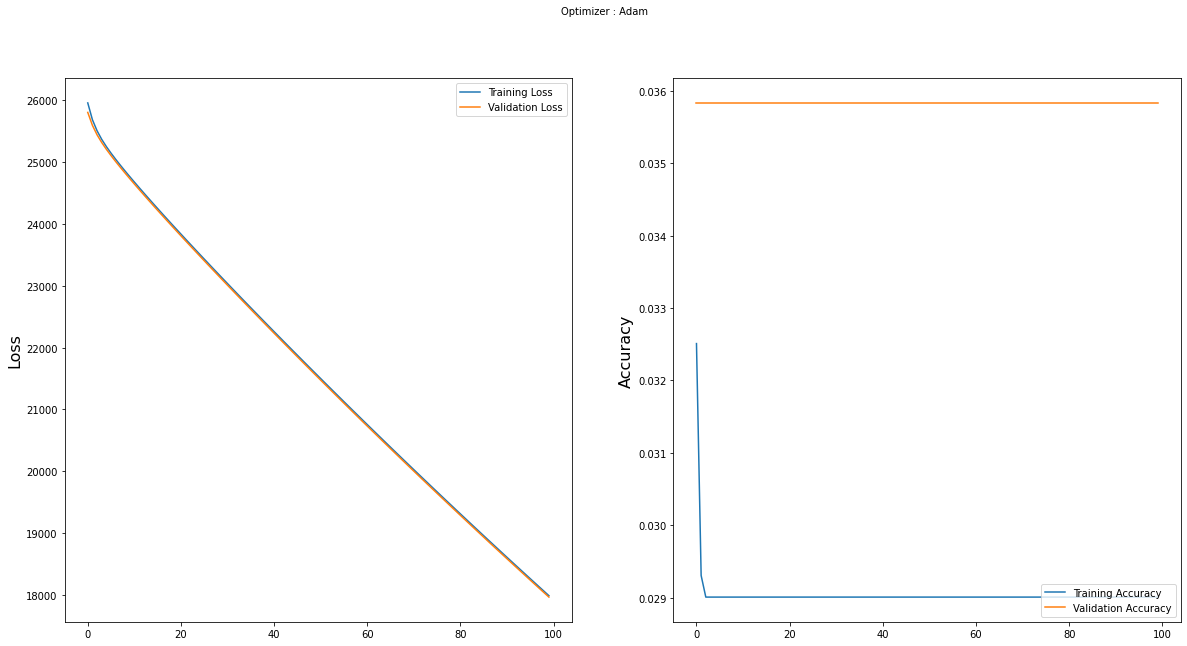

In [9]:
df2 = df.loc['2020-02-15 00:00:00' : '2020-04-07 00:00:00']

subset = df2[['feed_flow', 'feed_concentration', 'feed_temperature', 'stage_1_feed_pressure']]

#Imputing missing values with mean vaues of features

subset['feed_flow'] = subset['feed_flow'].fillna(subset['feed_flow'].mean())
subset['feed_concentration'] = subset['feed_concentration'].fillna(subset['feed_concentration'].mean())
subset['feed_temperature'] = subset['feed_temperature'].fillna(subset['feed_temperature'].mean())
subset['stage_1_feed_pressure'] = subset['stage_1_feed_pressure'].fillna(subset['stage_1_feed_pressure'].mean())


df_train = subset['2020-02-15':'2020-03-20'].copy() 
df_test = subset['2020-03-21':'2020-04-07'].copy() 

np.random.seed(1)

entire_train= df_train.values
entire_test = df_test.values

#Previous 15 mins (look_back)  used to predict next 15mins/timesteps(pred_length). 
look_back = 15
pred_length = 15


train, test = entire_train[:,:], entire_test[:,:]
print("train shape", train.shape)

#Covert into supervised problem. Input -> Output using Sequence of previous 
#time steps to generate future time steps
# Eg. T1, T2, T3 -> T4
#     T2, T3, T4 -> T5
def create_subSeq(dataseries, look_back, pred_length):
    ip, op = [], []
    for i in range(len(dataseries)):
        ip_index = i + look_back
        op_index = ip_index + pred_length
        if(op_index > len(dataseries)):
            break
        seq_x, seq_y = dataseries[i:ip_index, :], dataseries[ip_index:op_index, 0]
        ip.append(seq_x)
        op.append(seq_y)
    return np.array(ip), np.array(op)


X_train, Y_train = create_subSeq(train, look_back, pred_length)
X_test, Y_test = create_subSeq(test, look_back, pred_length)


Y_test_list = Y_test

# reshape from [samples, timesteps] into [samples, timesteps, features]-> 3D array as input to LSTM
# sample = number of samples, timesteps= look_back, features = 4
n_features = 4
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

#reshape Y's as [samples, timesteps]-> samples, pred_length
Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1]))
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1]))


model = Sequential()
model.add(LSTM(1024,activation ='tanh', input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(512,activation ='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(256,activation ='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128,activation ='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(64,activation ='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(pred_length))

adam = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=100, batch_size=512, validation_split=0.2,verbose=2,shuffle=False)



plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


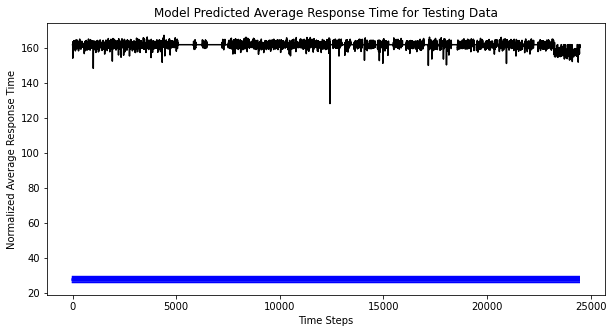

In [10]:
#Prediction of Y_train and Y_test
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

ytrainlist = []
ytrainpredlist = []
ytestpredlist = []
ytestlist = []
l=0


for i in range(testPredict.shape[0]-1):
  ytestpredlist.append(testPredict[i][0])
  ytestlist.append(Y_test[i][0])
  l=i

for i in range(trainPredict.shape[0]-1):
  ytrainlist.append(Y_train[i][0])
  ytrainpredlist.append(trainPredict[i][0])



last_row_index = testPredict.shape[0]-1

for i in range(testPredict.shape[1]):
  ytestpredlist.append(testPredict[last_row_index][i])
  ytestlist.append(Y_test[last_row_index][i])

for i in range(trainPredict.shape[1]):
  ytestpredlist.append(trainPredict[last_row_index][i])
  ytestlist.append(Y_train[last_row_index][i])


Y_test = np.array(ytestlist)
Y_test = Y_test.reshape((-1,1))


testPred = np.array(ytestpredlist)
testPred = testPred.reshape((-1,1))

Y_train = np.array(ytrainlist)
Y_train = Y_train.reshape((-1,1))

trainPred = np.array(ytrainpredlist)
trainPred = trainPred.reshape((-1,1))




plt.figure(figsize=(10,5))
plt.plot(Y_test, color = 'black', label = 'Average Response Time (Actual)')
plt.plot(testPredict, color = 'blue', label = 'Average Response Time (Predicted)')
plt.title('Model Predicted Average Response Time for Testing Data')
plt.ylabel('Normalized Average Response Time')
plt.xlabel('Time Steps')
plt.show(block = False)

In [ ]:
# This needs to be tuned with different parameters and run for more iterations to check how multivariate multistep LSTM works for this dataset